In [21]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib 

from activity_classifier import sigproc
from activity_classifier import ChunkableTimeSeries

plt.style.use('fivethirtyeight')

In [57]:
def noisy_sinusoid(n, a, f, fs, offset=0, noise_level=0.0):
    t = np.arange(n) / fs
    x = a * np.sin(2 * np.pi * f * t)
    x = x +np.random.normal(size=n, loc=offset, scale=noise_level)
    return t, x


def sample_signal():
    t = np.arange(2800) / 100.
    x = np.concatenate(
        [np.full(400, 0.),
         noisy_sinusoid(n=2000, a=1., f=1., fs=FS, offset=1, noise_level=0.1)[1],
         np.full(400, 0.)]
    )
    return t, x

def _plot_filter_input_outputs(t, x, x_lp, x_hp, show_plot=True):
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    plt.plot(t, x, label='raw', linewidth=1)
    plt.plot(t, x_lp, label='lowpass', linewidth=1)
    plt.plot(t, x_hp, label='highpass', linewidth=1)
    plt.legend()
    if show_plot: 
        plt.show()
    return fig, ax

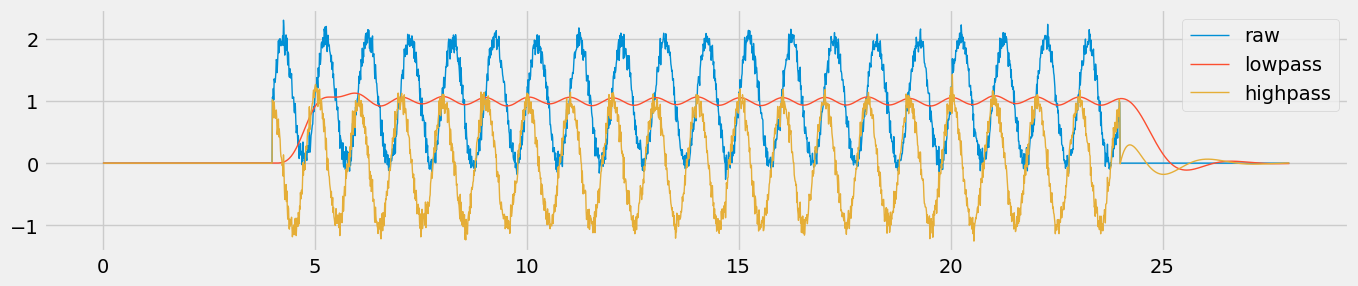

(<Figure size 1500x300 with 1 Axes>, <Axes: >)

In [62]:
# No transient handling
FS = 100. #Sample rate
#t, x = noisy_sinusoid(n=2000, a=1., f=1., fs=FS, offset=1, noise_level=0.1)
t, x = sample_signal()

lp = sigproc.SmartIIRFilter(
    signal.butter, 'lowpass', order=4, cutoff=0.5, fs=FS, transient_drop_t=None)
hp = sigproc.SmartIIRFilter(
    signal.butter, 'highpass', order=4, cutoff=0.5, fs=FS, transient_drop_t=None)

x_lp = lp.apply(x)
x_hp = hp.apply(x)
_plot_filter_input_outputs(t, x, x_lp, x_hp)


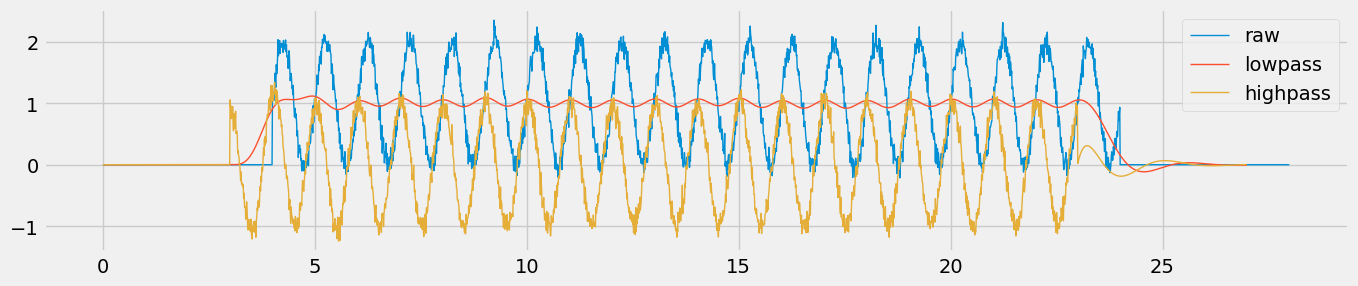

(<Figure size 1500x300 with 1 Axes>, <Axes: >)

In [71]:
# No transient handling, nut apply time shift (should shift output times backward by 0.5/cutoff)
FS = 100. #Sample rate
t, x = sample_signal()

lp = sigproc.SmartIIRFilter(
    signal.butter, 'lowpass', order=4, cutoff=0.5, fs=FS,
    perform_time_shift=True, transient_drop_t=None)
hp = sigproc.SmartIIRFilter(
    signal.butter, 'highpass', order=4, cutoff=0.5, fs=FS,
    perform_time_shift=True, transient_drop_t=None)

x_lp = lp.apply(x, t=t)
x_hp = hp.apply(x, t=t)
_plot_filter_input_outputs(t, x, x_lp, x_hp)


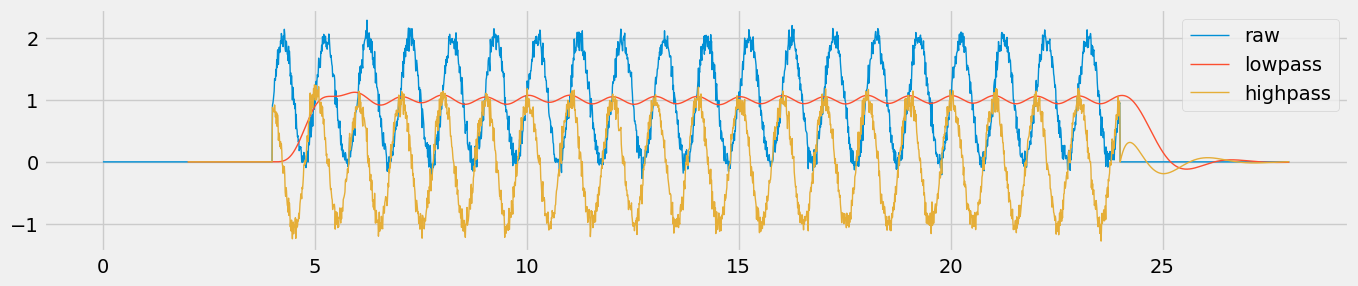

In [72]:
# Initial transient - we expect to to drop the first 2 seconds of data
t, x = sample_signal()

lp = sigproc.SmartIIRFilter(
    signal.butter, 'lowpass', order=4, cutoff=0.5, fs=100., transient_drop_t=2.)
hp = sigproc.SmartIIRFilter(
    signal.butter, 'highpass', order=4, cutoff=0.5, fs=100., transient_drop_t=2.)
#x_lp = lp.apply(x) # Raises error, as expected
#x_hp = hp.apply(x) # Raises error, as expected
x_lp = lp.apply(x, t=t)
x_hp = hp.apply(x, t=t)
_plot_filter_input_outputs(t, x, x_lp, x_hp);


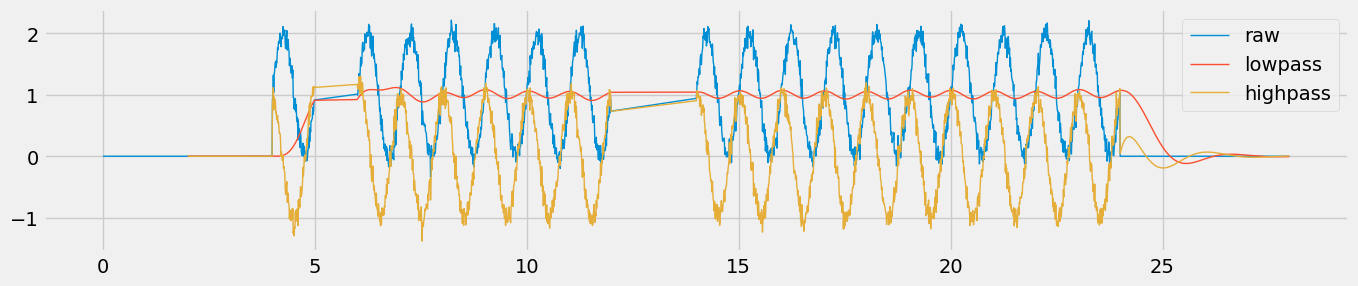

In [73]:
# Initial transient + unhandled gaps because they are smaller than transient_drop_t
t, x = sample_signal()

t = np.concatenate([t[0:500], t[600:1200], t[1400:]])
x = np.concatenate([x[0:500], x[600:1200], x[1400:]])

lp = sigproc.SmartIIRFilter(
    signal.butter, 'lowpass', order=4, cutoff=0.5, fs=100., transient_drop_t=2.)
hp = sigproc.SmartIIRFilter(
    signal.butter, 'highpass', order=4, cutoff=0.5, fs=100., transient_drop_t=2.)
x_lp = lp.apply(x, t=t)
x_hp = hp.apply(x, t=t)
_plot_filter_input_outputs(t, x, x_lp, x_hp);


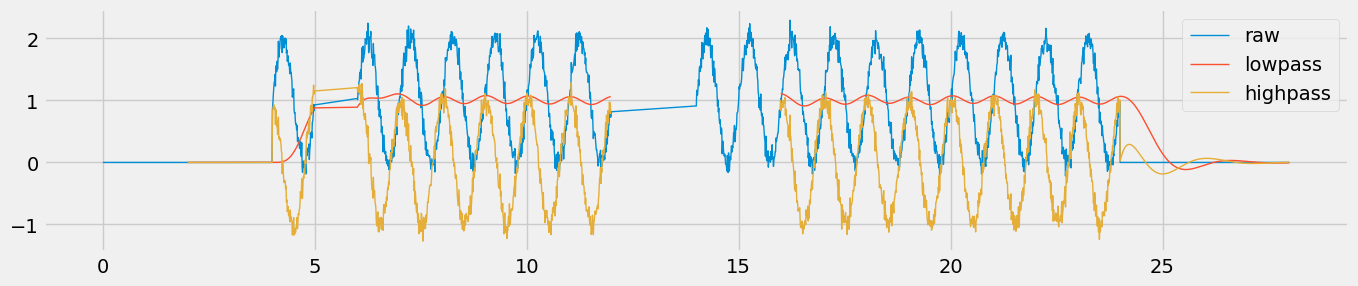

(<Figure size 1500x300 with 1 Axes>, <Axes: >)

In [75]:
# Initial transient + 1 identified gaps
t, x = sample_signal()

t = np.concatenate([t[0:500], t[600:1200], t[1400:]])
x = np.concatenate([x[0:500], x[600:1200], x[1400:]])

lp = sigproc.SmartIIRFilter(
    signal.butter, 'lowpass', order=4, cutoff=0.5, fs=100., transient_drop_t=2., max_t_gap=1.5)
hp = sigproc.SmartIIRFilter(
    signal.butter, 'highpass', order=4, cutoff=0.5, fs=100., transient_drop_t=2., max_t_gap=1.5)
x_lp = lp.apply(x, t=t)
x_hp = hp.apply(x, t=t)
_plot_filter_input_outputs(t, x, x_lp, x_hp)


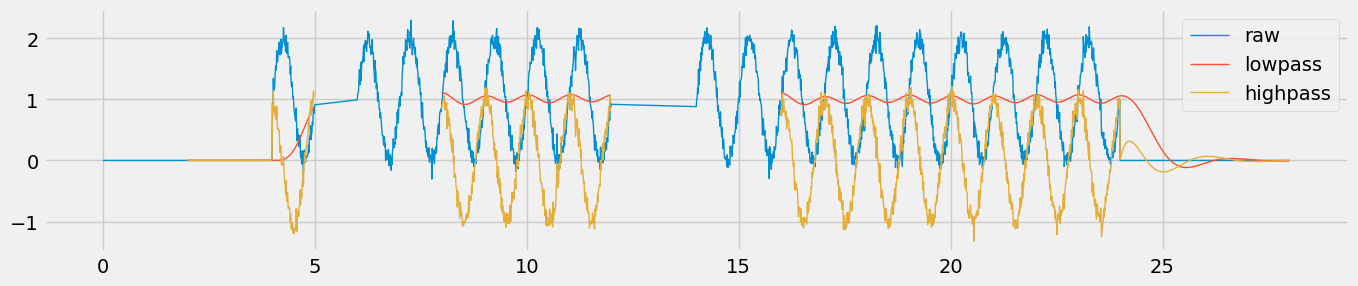

(<Figure size 1500x300 with 1 Axes>, <Axes: >)

In [76]:
# Initial transient + 2 identified gaps
t, x = sample_signal()

t = np.concatenate([t[0:500], t[600:1200], t[1400:]])
x = np.concatenate([x[0:500], x[600:1200], x[1400:]])

lp = sigproc.SmartIIRFilter(signal.butter, 'lowpass', order=4, cutoff=0.5, fs=100., transient_drop_t=2., max_t_gap=0.5)
hp = sigproc.SmartIIRFilter(signal.butter, 'highpass', order=4, cutoff=0.5, fs=100., transient_drop_t=2., max_t_gap=0.5)
x_lp = lp.apply(x, t=t)
x_hp = hp.apply(x, t=t)
_plot_filter_input_outputs(t, x, x_lp, x_hp)


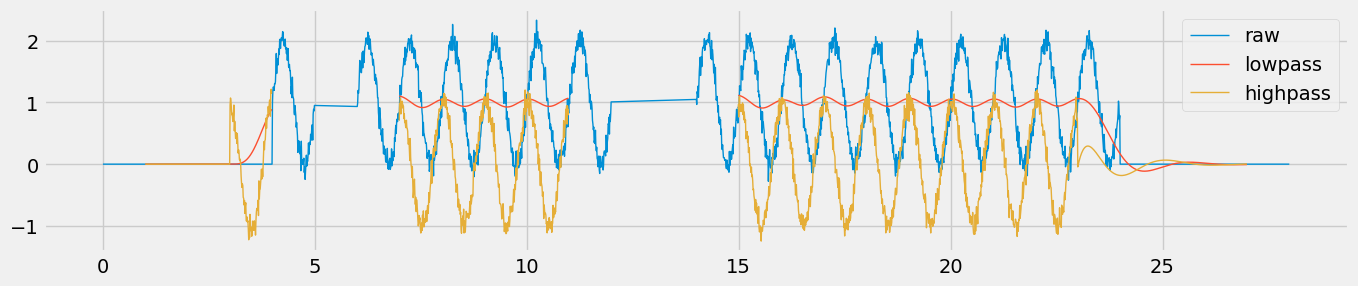

(<Figure size 1500x300 with 1 Axes>, <Axes: >)

In [77]:
# Initial transient + 2 identified gaps with time shift requested
t, x = sample_signal()

t = np.concatenate([t[0:500], t[600:1200], t[1400:]])
x = np.concatenate([x[0:500], x[600:1200], x[1400:]])

lp = sigproc.SmartIIRFilter(
    signal.butter, 'lowpass', order=4, cutoff=0.5, fs=100.,
     perform_time_shift=True, transient_drop_t=2.,max_t_gap=0.5)
hp = sigproc.SmartIIRFilter(
    signal.butter, 'highpass', order=4, cutoff=0.5, fs=100., 
     perform_time_shift=True, transient_drop_t=2., max_t_gap=0.5)
x_lp = lp.apply(x, t=t)
x_hp = hp.apply(x, t=t)
_plot_filter_input_outputs(t, x, x_lp, x_hp)


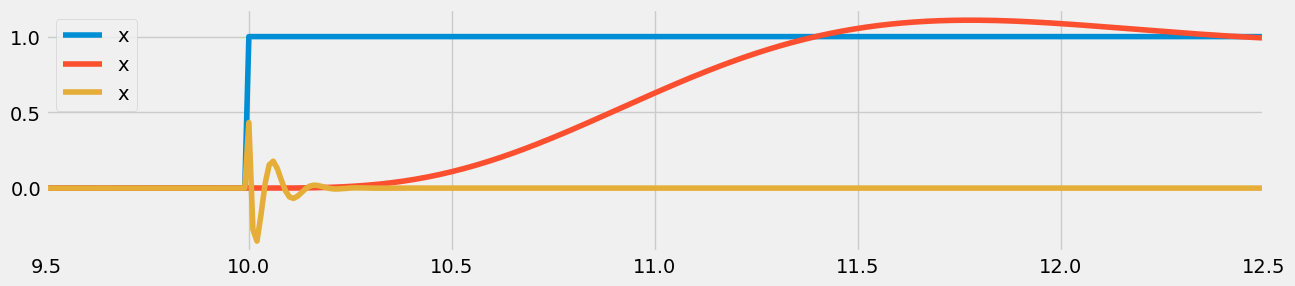

In [78]:
## Examine time delays
FS = 100


x = np.array([0] * 1000 + [1] * 1000)
t = np.arange(len(x)) / FS
cts = ChunkableTimeSeries(
    df=pd.DataFrame(data={'timestamp': t, 'x': x}),
    time_col='timestamp',
    value_cols=['x'],
    annot_cols=[]
)
hp_filter = sigproc.SmartIIRFilter(
    signal.butter, 'highpass', order=4, cutoff=10, fs=100., transient_drop_t=0.)
lp_filter = sigproc.SmartIIRFilter(
    signal.butter, 'lowpass', order=4, cutoff=0.5, fs=100., transient_drop_t=0.)

cts_lp = cts.apply_smart_filter(lp_filter, inplace=False)
cts_hp = cts.apply_smart_filter(hp_filter, inplace=False)

fig, ax = cts.plot(show_plot=False)
cts_lp.plot(ax=ax, show_plot=False)
cts_hp.plot(ax=ax, show_plot=False)
ax.set_xlim(9.5, 12.5)
plt.show()
